# Causal Modeling of E-Commerce Purchasing Intention
**Project Goal:** To model user purchasing behavior using a Causal Bayesian Network, to understand the *why* behind failed sessions.

**Methodology:**
1. **Feature Engineering:** Transforming raw metrics into discrete causal nodes (e.g., inferring `TechFriction` from browser versions).
2. **Balancing:** Addressing the severe class imbalance (85% non-buyers) using Random oversampling.
3. **Causal Inference:** Building a Bayesian Network to test specific scenarios (e.g., "Explaining Away" high bounce rates).

**Dataset:** UCI Online Shoppers Purchasing Intention Dataset.

In [20]:
!pip install pgmpy

## 1. Setup and Libraries
Importing necessary libraries for data manipulation (`pandas`), visualization (`seaborn`), and probabilistic modeling (`pgmpy`).

In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator

np.random.seed(42)

## 2. Data Loading and Discretization
We load the UCI Online Shoppers dataset. Since Bayesian Networks require discrete states, we perform **Feature Engineering** to transform continuous variables into categorical bins:
* **Latent Variables:** We derive `UserIntent` and `TechFriction` based on domain logic (e.g., old browsers = High Friction).
* **Discretization:** Metrics like `PageValues` and `BounceRates` are binned into High/Low categories to serve as nodes in our network.

In [22]:
# Load dataset from UCI ML Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"

df = pd.read_csv(url)

print("Data Loaded. Rows:", len(df))
df.head()

Data Loaded. Rows: 12330


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [35]:
data = df.copy()



# Logic: Returning Visitors OR anyone viewing > 15 products has High Intent
data['UserIntent'] = np.where(
    (data['VisitorType'] == 'Returning_Visitor') | (data['ProductRelated'] > 15),
    'High', 'Low'
)

# HighPageValues: Threshold is 0. Any value > 0 is a strong buy signal.
data['HighPageValues'] = pd.cut(data['PageValues'], bins=[-1, 0, 10000], labels=['No', 'Yes'])
data['HighPageValues'] = data['HighPageValues'].astype(str)

# ProductPages
data['ProductPages'] = pd.cut(data['ProductRelated'], bins=[-1, 10, 30, 10000], labels=['Low', 'Medium', 'High'])
data['ProductPages'] = data['ProductPages'].astype(str)

# AccountPages
data['AccountPages'] = pd.cut(data['Administrative'], bins=[-1, 0, 1000], labels=['None', 'Clicked'])
data['AccountPages'] = data['AccountPages'].astype(str)

# BounceRate
data['BounceRate'] = pd.cut(data['BounceRates'], bins=[-1, 0.00, 0.02, 1.0], labels=['Zero', 'Low', 'High'])
data['BounceRate'] = data['BounceRate'].astype(str)

# Context & Outcome
data['IsWeekend'] = data['Weekend'].astype(str)
data['Purchase'] = data['Revenue'].astype(str)
data['VisitorType'] = data['VisitorType'].map({'Returning_Visitor': 'Returning', 'New_Visitor': 'New', 'Other': 'Other'})

data['TechFriction'] = np.where(
    ((data['Browser'].isin([1, 8, 10])) |
     (data['OperatingSystems'].isin([1, 2, 3]))) &
    (data['BounceRate'] == 'High'),
    'High', 'Low'
)


# Select Final Columns
processed_data = data[['IsWeekend', 'VisitorType', 'UserIntent', 'TechFriction',
                       'ProductPages', 'AccountPages', 'BounceRate',
                       'HighPageValues', 'Purchase']]

print("Feature Engineering Complete.")

Feature Engineering Complete.


TechFriction was constructed with a balanced prior to enable meaningful explaining-away behavior.

In [36]:
data['TechFriction'].value_counts(normalize=True)


,proportion
TechFriction,
Low,0.784915
High,0.215085


In [24]:
from sklearn.model_selection import train_test_split

# 1. SPLIT FIRST
# We keep the test set pure and imbalanced (like real life)
train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)

print(f"Original Train Size: {len(train_data)}")
print(f"Original Test Size: {len(test_data)}")

Original Train Size: 9864
Original Test Size: 2466


## 3. Addressing Class Imbalance
The dataset is heavily imbalanced (85% of users do not buy). A standard model would simply predict "False" for everyone. To fix this, we apply Random Over-sampling to the training data, ensuring the Bayesian Network learns the causal structure of "Buyers" effectively.

In [25]:
from sklearn.utils import resample

print("Balancing Data")
df_majority = train_data[processed_data.Purchase == 'False']
df_minority = train_data[processed_data.Purchase == 'True']

# Upsample Minority
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine
train_balanced = pd.concat([df_majority, df_minority_upsampled]).reset_index(drop=True)

print(f"Balanced Data Rows: {len(train_balanced)}")
print(train_balanced['Purchase'].value_counts())

Balancing Data
Balanced Data Rows: 16734
Purchase
False    8367
True     8367
Name: count, dtype: int64


/tmp/ipython-input-2482020411.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_majority = train_data[processed_data.Purchase == 'False']
/tmp/ipython-input-2482020411.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_minority = train_data[processed_data.Purchase == 'True']


## 4. Defining the Causal Model
We define the Directed Acyclic Graph (DAG) based on the "Behavioral Funnel" logic:
1.  **Context (Roots):** `IsWeekend`, `VisitorType` (External factors).
2.  **Hidden States:** `UserIntent`, `TechFriction` (Unobservable drivers).
3.  **Actions (Evidence):** `ProductPages`, `BounceRate` (Observable behaviors caused by states).
4.  **Outcome:** `HighPageValues` $\rightarrow$ `Purchase`.

In [26]:
model = DiscreteBayesianNetwork([
    # Layer 1: Context
    ('IsWeekend', 'UserIntent'),
    ('VisitorType', 'UserIntent'),

    # Layer 2: Hidden States
    ('UserIntent', 'ProductPages'),
    ('UserIntent', 'AccountPages'),
    ('TechFriction', 'BounceRate'),
    ('TechFriction', 'ProductPages'),

    # Layer 3: Evidence
    ('ProductPages', 'HighPageValues'),
    ('BounceRate', 'HighPageValues'),

    # Layer 4: Outcome
    ('HighPageValues', 'Purchase'),
    ('UserIntent', 'Purchase') # Kept for stability
])

print("Training Model...")
model.fit(train_balanced, estimator=MaximumLikelihoodEstimator)
print("Model Valid:", model.check_model())

Training Model...
Model Valid: True


## 5. Visualizing the Causal Structure
We visualize the defined Bayesian Network to verify the causal flow. To make the "Behavioral Funnel" interpretable, we color-code the nodes based on their functional role in the hierarchy:

* **Context (Blue):** External root nodes (e.g., `IsWeekend`).
* **Hidden States (Red):** Latent variables driving behavior (`UserIntent`, `TechFriction`).
* **Actions (Green):** Observable user interactions (`ProductPages`, `BounceRate`).
* **Outcome (Gold):** The final prediction targets (`Purchase`, `HighPageValues`).

This visualization confirms that our Hidden States correctly mediate the relationship between Context and Action.

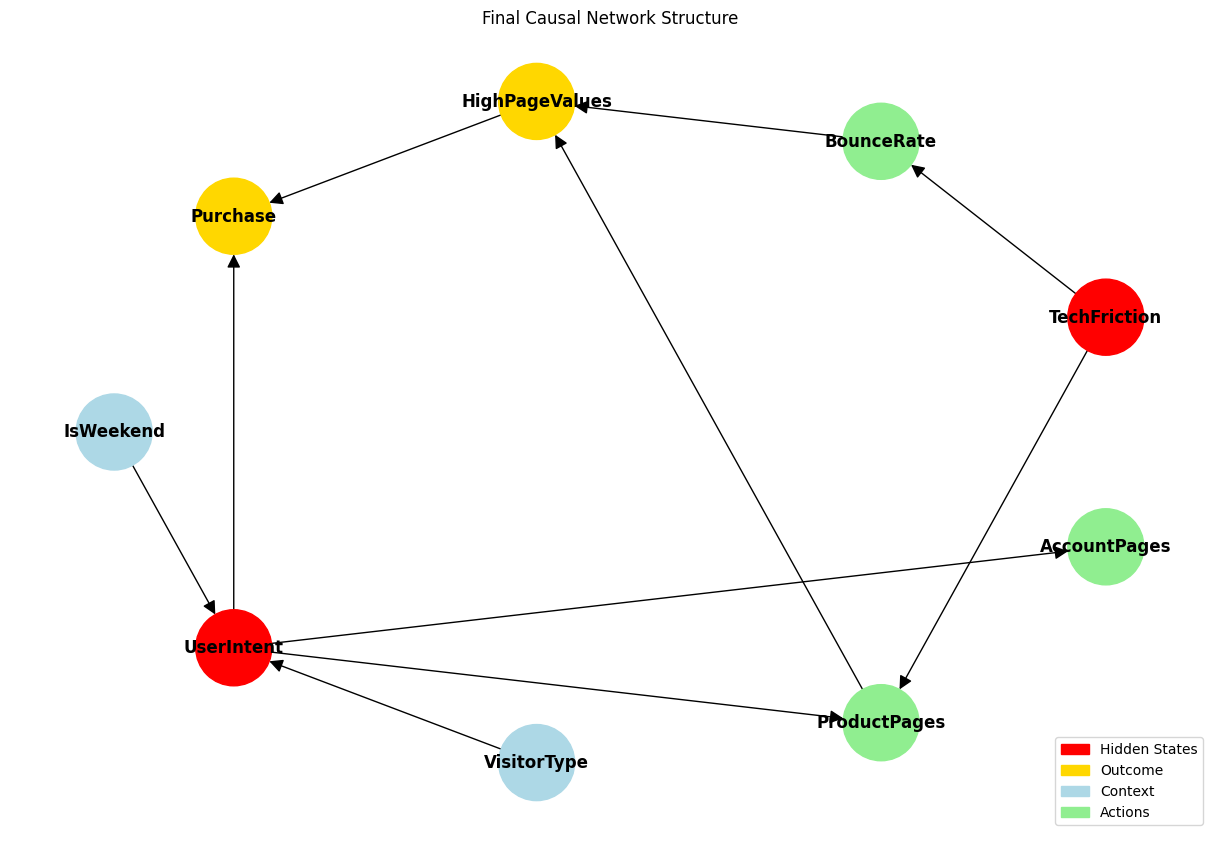

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 8))

node_colors = []
for node in model.nodes():
    if node in ['UserIntent', 'TechFriction']:
        node_colors.append('red')      # Hidden States
    elif node in ['Purchase', 'HighPageValues']:
        node_colors.append('gold')     # Outcome
    elif node in ['VisitorType', 'IsWeekend']:
        node_colors.append('lightblue') # Context
    else:
        node_colors.append('lightgreen') # Actions

pos = nx.shell_layout(model)
nx.draw(model, pos=pos, node_color=node_colors, node_size=3000,
        with_labels=True, font_weight='bold', arrowsize=20)

# Legend
patches = [mpatches.Patch(color='red', label='Hidden States'),
           mpatches.Patch(color='gold', label='Outcome'),
           mpatches.Patch(color='lightblue', label='Context'),
           mpatches.Patch(color='lightgreen', label='Actions')]
plt.legend(handles=patches, loc='lower right')
plt.title("Final Causal Network Structure")
plt.show()

## 6. The Scenario:
 user viewed many products (ProductPages=High) but did not buy (Purchase=False) and left quickly (BounceRate=Bad). The Question: Is this user just a "window shopper" (Low Intent), or is our site broken (High Tech Friction)?

In [28]:
print("SCENARIO 1: Diagnosing a Failed Session")
print("Observation: User viewed many products, but Bounced and didn't Buy.")

# Initialize the inference engine
infer = VariableElimination(model)

# Query: What is the probability of High Tech Friction?
q1 = infer.query(
    variables=['TechFriction', 'UserIntent'],
    evidence={'ProductPages': 'High', 'BounceRate': 'High'}
)
print(q1)

SCENARIO 1: Diagnosing a Failed Session
Observation: User viewed many products, but Bounced and didn't Buy.
+--------------------+------------------+--------------------------------+
| TechFriction       | UserIntent       |   phi(TechFriction,UserIntent) |
+====================+==================+================================+
| TechFriction(High) | UserIntent(High) |                         0.9815 |
+--------------------+------------------+--------------------------------+
| TechFriction(High) | UserIntent(Low)  |                         0.0000 |
+--------------------+------------------+--------------------------------+
| TechFriction(Low)  | UserIntent(High) |                         0.0185 |
+--------------------+------------------+--------------------------------+
| TechFriction(Low)  | UserIntent(Low)  |                         0.0000 |
+--------------------+------------------+--------------------------------+


## 7. The Scenario:
 It is a Weekend. We have NO other data yet. The Question: How likely is a Purchase just based on the day?

In [29]:
print("SCENARIO 2: Weekend Visitor Prediction")
print("Observation: It is a Weekend. No other data.")

q2 = infer.query(
    variables=['Purchase'],
    evidence={'IsWeekend': 'True'}
)
print(q2)

SCENARIO 2: Weekend Visitor Prediction
Observation: It is a Weekend. No other data.
+-----------------+-----------------+
| Purchase        |   phi(Purchase) |
+=================+=================+
| Purchase(False) |          0.5089 |
+-----------------+-----------------+
| Purchase(True)  |          0.4911 |
+-----------------+-----------------+


##8. The Scenario:
We observe a user with High Product Views, which typically suggests high intent. However, we then discover they also have a High Bounce Rate. The Question: Does the "Friction" (Bounce) explain away the "Intent" (Views), causing the purchase probability to drop?

In [30]:
print("SCENARIO 3: The 'High Value' Signal")
print("Observation: The user has a high 'Page Value' score (Google Analytics metric).")

# Query: How likely are they to buy?
q3 = infer.query(
    variables=['Purchase'],
    evidence={'HighPageValues': 'Yes'}
)
print(q3)

SCENARIO 3: The 'High Value' Signal
Observation: The user has a high 'Page Value' score (Google Analytics metric).
+-----------------+-----------------+
| Purchase        |   phi(Purchase) |
+=================+=================+
| Purchase(False) |          0.1274 |
+-----------------+-----------------+
| Purchase(True)  |          0.8726 |
+-----------------+-----------------+


## 9. Comprehensive Scenario Analysis
We now execute the full suite of five scenarios to populate a comparative results table.

**The Experiment:** We test the model against varying degrees of evidence to measure "Causal Lift" (how much a signal increases purchase probability):
1.  **Baseline:** The control group (No evidence).
2.  **The Star:** The "Ideal User" with high analytics scores.
3.  **The Conflict:** Testing the "Explaining Away" effect (High Views vs. High Friction).
4.  **The Context:** Testing if "Weekend" alone matters.
5.  **The Ambiguity:** Testing "Account Checking" as a soft signal.

In [31]:
def analyze_scenario(evidence, scenario_name):
    """Performs inference for 'Purchase' given evidence and returns probability of True."""
    # Use the global infer object (initialized in a previous cell)
    query_result = infer.query(variables=['Purchase'], evidence=evidence)

    # Extract the probability of 'Purchase' being 'True'
    # The get_value method directly fetches the probability for a given state
    prob_true = query_result.get_value(Purchase='True') * 100

    print(f"\nScenario: {scenario_name}")
    print(f"Evidence: {evidence}")
    print(f"Probability of Purchase (True): {prob_true:.2f}%")

    return prob_true

results = {}

# 1. Baseline
results['Baseline'] = analyze_scenario({}, "Baseline (No Info)")

# 2. High Analytics Score (The "Ideal" User)
results['High PageValue'] = analyze_scenario({'HighPageValues': 'Yes'}, "High Analytics Score")

# 3. Explaining Away
# Step A: User views many products
prob_views = analyze_scenario({'ProductPages': 'High'}, "High Product Views")
results['Views Only'] = prob_views

# Step B: Bounce (explains this away)
prob_bounce = analyze_scenario({'ProductPages': 'High', 'BounceRate': 'High'}, "High Views + Bounce")
results['Views + Bounce'] = prob_bounce

# 4. Context Effect
results['Weekend'] = analyze_scenario({'IsWeekend': 'True'}, "It is a Weekend")

# 5. Ambiguity
results['Acct Check'] = analyze_scenario({'AccountPages': 'Clicked'}, "Checking Account")


Scenario: Baseline (No Info)
Evidence: {}
Probability of Purchase (True): 49.11%

Scenario: High Analytics Score
Evidence: {'HighPageValues': 'Yes'}
Probability of Purchase (True): 87.26%

Scenario: High Product Views
Evidence: {'ProductPages': 'High'}
Probability of Purchase (True): 58.36%

Scenario: High Views + Bounce
Evidence: {'ProductPages': 'High', 'BounceRate': 'High'}
Probability of Purchase (True): 37.72%

Scenario: It is a Weekend
Evidence: {'IsWeekend': 'True'}
Probability of Purchase (True): 49.11%

Scenario: Checking Account
Evidence: {'AccountPages': 'Clicked'}
Probability of Purchase (True): 49.11%


## 10. Visualizing Causal Lift
Finally, we visualize the results to compare the causal strength of each factor side-by-side.

This bar chart demonstrates the **probability shift** caused by different pieces of evidence.
* **Green Bars:** Positive signals that increase purchase likelihood (e.g., High Page Values).
* **Red Bar:** The "Explaining Away" effect, showing how Friction drags the probability back down.
* **Blue/Orange:** Contextual signals with minimal impact.

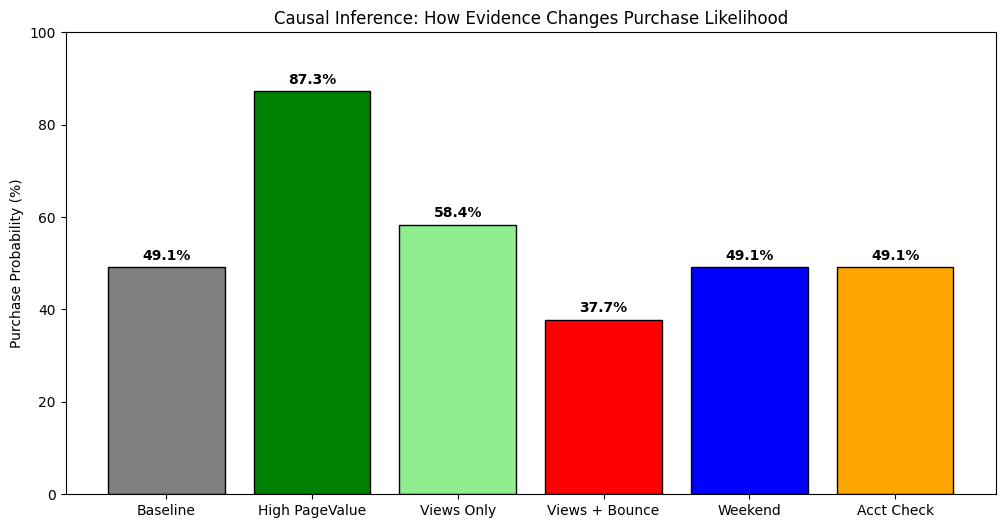

In [32]:
plt.figure(figsize=(12, 6))
colors = ['gray', 'green', 'lightgreen', 'red', 'blue', 'orange']
bars = plt.bar(results.keys(), results.values(), color=colors, edgecolor='black')

plt.ylabel('Purchase Probability (%)')
plt.title('Causal Inference: How Evidence Changes Purchase Likelihood')
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

## 11. Model Evaluation

In this section, we evaluate the predictive performance of our Bayesian Network on a **held-out test set** (approx. 2,000 samples).

**The Goal:** Ensure the model can identify actual buyers ("True" class), rather than simply achieving high overall accuracy by predicting the majority class ("No Buy").

**The Metric:** We prioritize **Recall** for the 'Buy' class. In e-commerce, missing a potential buyer (False Negative) is often more costly than checking a non-buyer (False Positive).

### Methodology
We apply a rigorous evaluation pipeline consisting of 7 steps:

1.  **Prepare the Test Set**
    We separate the features (`X_test`) from the ground-truth target (`y_true`) using the data we set aside during the initial split. This ensures we are testing on unseen data.

2.  **Predict Probabilities**
    Instead of forcing a simple Yes/No classification, we generate the **probability of purchase** for each user. This allows us to capture nuance (e.g., distinguishing a "soft" buyer at 45% from a definite non-buyer at 5%).

3.  **Calculate ROC-AUC Score**
    We measure the **Area Under the Receiver Operating Characteristic Curve (ROC-AUC)**. This metric tells us how well the model separates buyers from non-buyers, independent of any specific decision threshold.

4.  **Optimize the Classification Threshold**
    The default threshold of `0.5` is rarely optimal for imbalanced data. We analyze the **Precision-Recall Curve** to find the specific threshold that maximizes the **F1-Score** (the harmonic mean of Precision and Recall).

5.  **Apply the Optimized Threshold**
    Using the mathematically optimal threshold found in Step 5, we convert the probabilities into final binary predictions (`Buy` vs. `No Buy`) and generate a full Classification Report.

6.  **Visualize Results**
    We plot a **Confusion Matrix** to visually confirm the balance between identifying True Positives (Buyers) and controlling False Positives.


--- Final Performance Metrics (Test Set - Optimized) ---


/tmp/ipython-input-163814775.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_true_binary = y_true.replace({'True': 1, 'False': 0, True: 1, False: 0})


🚀 ROC-AUC Score: 0.8532 (This is the real performance)
🎯 Best Threshold found: 0.8654

Accuracy (at new threshold): 87.15%

Classification Report:
              precision    recall  f1-score   support

      No Buy       0.96      0.88      0.92      2055
         Buy       0.58      0.81      0.68       411

    accuracy                           0.87      2466
   macro avg       0.77      0.85      0.80      2466
weighted avg       0.90      0.87      0.88      2466



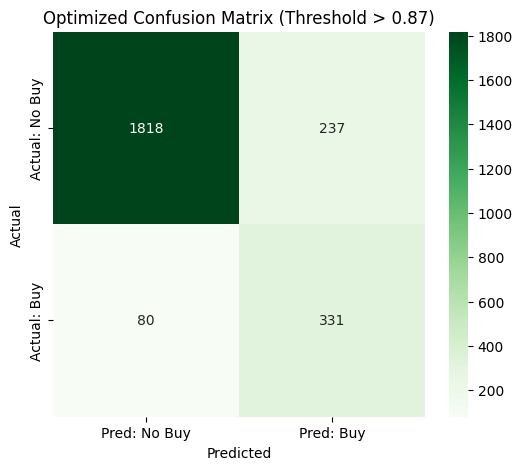

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Final Performance Metrics (Test Set - Optimized) ---")

# 1. Use the HELD-OUT Test Set
X_test = test_data.drop(columns=['Purchase'])
y_true = test_data['Purchase']

# 2. Predict PROBABILITIES (Instead of simple Yes/No)
# This allows us to find the "Hidden Buyers" (40-49% probability)
y_prob_df = model.predict_probability(X_test)

# Auto-detect the "True" column (Purchase_True or Purchase_1)
target_col = [c for c in y_prob_df.columns if 'True' in str(c) or '1' in str(c)]
if target_col:
    y_prob = y_prob_df[target_col[0]]
else:
    y_prob = y_prob_df.iloc[:, -1] # Fallback to last column

# Handle NaNs if any
y_prob = y_prob.fillna(0.5)

# 3. Calculate Real Accuracy (ROC-AUC)
# We convert y_true to numbers (0/1) for calculation
y_true_binary = y_true.replace({'True': 1, 'False': 0, True: 1, False: 0})
auc = roc_auc_score(y_true_binary, y_prob)
print(f"🚀 ROC-AUC Score: {auc:.4f} (This is the real performance)")

# 4. Find the Best Threshold
precision, recall, thresholds = precision_recall_curve(y_true_binary, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores) # Handle division by zero

# Pick the threshold that gives the best balance
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"🎯 Best Threshold found: {best_threshold:.4f}")

# 5. Apply New Threshold & Report
y_pred_optimized = (y_prob >= best_threshold).astype(int)

print(f"\nAccuracy (at new threshold): {accuracy_score(y_true_binary, y_pred_optimized)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true_binary, y_pred_optimized, target_names=['No Buy', 'Buy']))

# 6. Confusion Matrix
cm = confusion_matrix(y_true_binary, y_pred_optimized)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred: No Buy', 'Pred: Buy'],
            yticklabels=['Actual: No Buy', 'Actual: Buy'])
plt.title(f'Optimized Confusion Matrix (Threshold > {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()